# Project Proposal
Name: Dalton Carr

## About This Data Set

This project intends to explore a collection of databases which contain four separate datasets regarding heart disease, respectively for Cleveland, Hungary, Switzerland, and the VA Long Beach. This project intends to specifically focus on the Cleveland database. This database contains 14 separate variables and 303 observations, including the target variable (diagnosis of heart disease), and 13 feature variables which consist of age (years), sex, chest pain, resting blood pressure (in mm Hg on admission to the hospital), serum cholestoral(mg/dl), fasting blood sugar > 120 mg/dl, resting electrocardiographic results, maximum heart rate achieved, exercise-induced angina, ST depression induced by exercise relative to rest, the slope of the peak exercise ST segment, number of major vessels, and thalassemia diagnosis.  

## The Question Project Intends to Answer

By utilizing observations made in the UCI Machine Learning Repository, Cleveland Heart Disease dataset. Can age, chest pain, and maximum heart rate achieved, be used to predict a diagnosis of heart disease?

## Loading Libraries

In [1]:
library(tidyverse)
library(tidymodels)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

## Reading and Wrangling Data

Below I first read the Cleveleand dataset into R and then provided the columns with appropriate names. I then filtered out the observations which contained missing values in the number of major vessels and/or thalassemia columns (as it was only 6 out of 303 columns I felt this was an appropriate solution). I then mutated the columns into the appropriate variable type. 

In [2]:
og_data <- read_csv("data/heart_disease/processed.cleveland.data", col_names = FALSE)
data <- og_data |>
    rename(age = X1, sex = X2, chest_pain = X3, resting_blood_pressure = X4, serum_cholestoral_mgdl = X5,
           fasting_blood_sugar = X6, resting_ecg_results = X7, maximum_heart_rate_achieved = X8,
           exercise_induced_angina = X9, ST_depression_induced_by_exercise_relative_to_rest = X10,
           slope_peak_exercise_ST_segment = X11, number_of_major_vessels = X12, thalassemia = X13, 
           diagnosis_of_heart_disease = X14) |>
    filter(number_of_major_vessels != "?", thalassemia != "?") |>
    mutate(sex = as_factor(sex), chest_pain = as_factor(chest_pain), fasting_blood_sugar = as_factor(fasting_blood_sugar),
           resting_ecg_results = as_factor(resting_ecg_results), exercise_induced_angina = as_factor(exercise_induced_angina),
           slope_peak_exercise_ST_segment = as_factor(slope_peak_exercise_ST_segment), thalassemia = as_factor(thalassemia),
           diagnosis_of_heart_disease = as_factor(diagnosis_of_heart_disease)) |>
    mutate(sex = fct_recode(sex, "male" = "1", "female" = "0"),
           chest_pain = fct_recode(chest_pain, "typical_angina" = "1", "atypical_angina" = "2", "non-anginal_pain" = '3', "asymptomatic" = "4"),
           fasting_blood_sugar = fct_recode(fasting_blood_sugar, "true" = "1", "false" = "0"),
           resting_ecg_results = fct_recode(resting_ecg_results, "normal" = "0", "having_ST-T_wave_abnormality" = "1", "left_ventricular_hypertrophy" = "2"),
           exercise_induced_angina = fct_recode(exercise_induced_angina, "yes" = "1", "no" = "0"),
           slope_peak_exercise_ST_segment = fct_recode(slope_peak_exercise_ST_segment, "unsloping" = "1", "flat" = "2", "downsloping" = "3"),
           thalassemia = fct_recode(thalassemia, "normal" = "3.0", "fixed_defect" = "6.0", "reversable_defect" = "7.0"),
           diagnosis_of_heart_disease = fct_recode(diagnosis_of_heart_disease, "no" = "0", "yes" = "1", "yes" = "2", "yes" = "3",
                                                  "yes" = "4")) |>
    mutate(number_of_major_vessels = as.double(number_of_major_vessels))   

na_count <- og_data |>
  filter(X12 == "?"| X13 == "?") |>
  summarize(count = n())
head(na_count)


head(data)


Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


count
<int>
6


age,sex,chest_pain,resting_blood_pressure,serum_cholestoral_mgdl,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,ST_depression_induced_by_exercise_relative_to_rest,slope_peak_exercise_ST_segment,number_of_major_vessels,thalassemia,diagnosis_of_heart_disease
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>
63,male,typical_angina,145,233,true,left_ventricular_hypertrophy,150,no,2.3,downsloping,0,fixed_defect,no
67,male,asymptomatic,160,286,false,left_ventricular_hypertrophy,108,yes,1.5,flat,3,normal,yes
67,male,asymptomatic,120,229,false,left_ventricular_hypertrophy,129,yes,2.6,flat,2,reversable_defect,yes
37,male,non-anginal_pain,130,250,false,normal,187,no,3.5,downsloping,0,normal,no
41,female,atypical_angina,130,204,false,left_ventricular_hypertrophy,172,no,1.4,unsloping,0,normal,no
56,male,atypical_angina,120,236,false,normal,178,no,0.8,unsloping,0,normal,no


## Splitting the Data into Training and Testing Data

In [3]:
set.seed(2007)
data_split <- initial_split(data, prop = 0.75, strata = diagnosis_of_heart_disease)
data_train <- training(data_split)
data_test <- testing(data_split)

## Summary Table

Below I have created two summary tables of the variables I have decided to explore. The first table consists of the mean of both the age and maximum heart rate achieved variables for the respective heart disease diagnosis. The second table relates the count of each value of chest pain and the respective diagnosis. 

In [4]:
summary_table <- data_train |>
    group_by(diagnosis_of_heart_disease) |>
    summarize(mean(maximum_heart_rate_achieved), mean(age), count = n())
summary_table

cp_table <- data_train |>
    group_by(chest_pain, diagnosis_of_heart_disease) |>
    summarize(count = n())
cp_table

diagnosis_of_heart_disease,mean(maximum_heart_rate_achieved),mean(age),count
<fct>,<dbl>,<dbl>,<int>
no,158.1833,53.37500,120
yes,137.9118,56.89216,102


`summarise()` has grouped output by 'chest_pain'. You can override using the
`.groups` argument.


chest_pain,diagnosis_of_heart_disease,count
<fct>,<fct>,<int>
typical_angina,no,11
typical_angina,yes,2
atypical_angina,no,31
atypical_angina,yes,7
non-anginal_pain,no,49
non-anginal_pain,yes,13
asymptomatic,no,29
asymptomatic,yes,80


## Relationship Between Diagnosis and Other Variables

Below I first decided to visualize the relationship between the diagnosis of the observations, when compared to age and maximum heart rate achieved through a scatter plot. I observed there appears to be a higher presence of heart disease in observations where the maximum heart rate achieved was under 150, with less presence in observations whose heart rate reached above that. There also appears to be a higher frequency of heart disease in observations with an age over 55, compared to those aged under. 
The second visualization relates the experienced chest pain compared to the actual heart disease diagnosis. It appears that the majority of observations diagnosed with heart disease were asymptomatic for chest pain.

Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


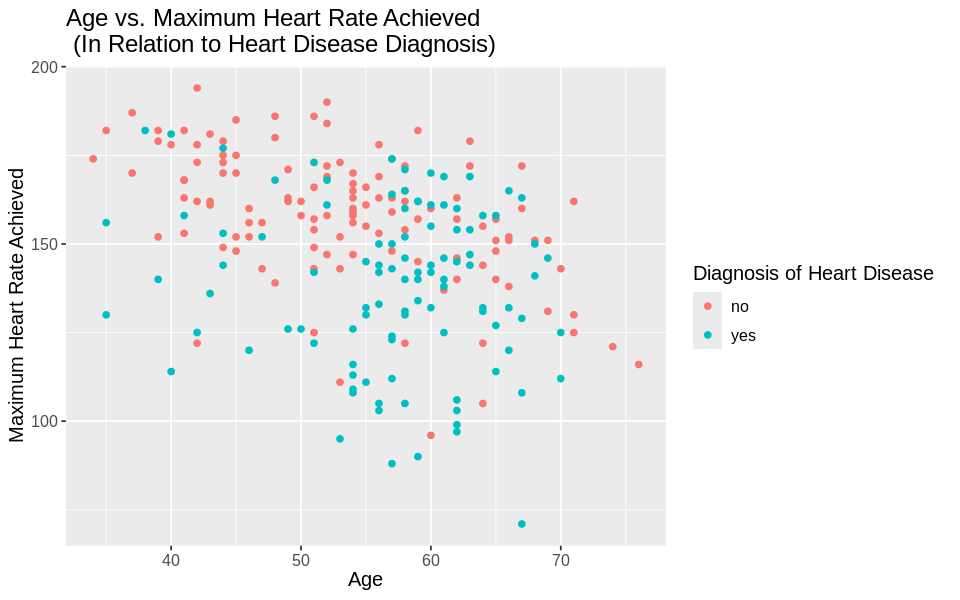

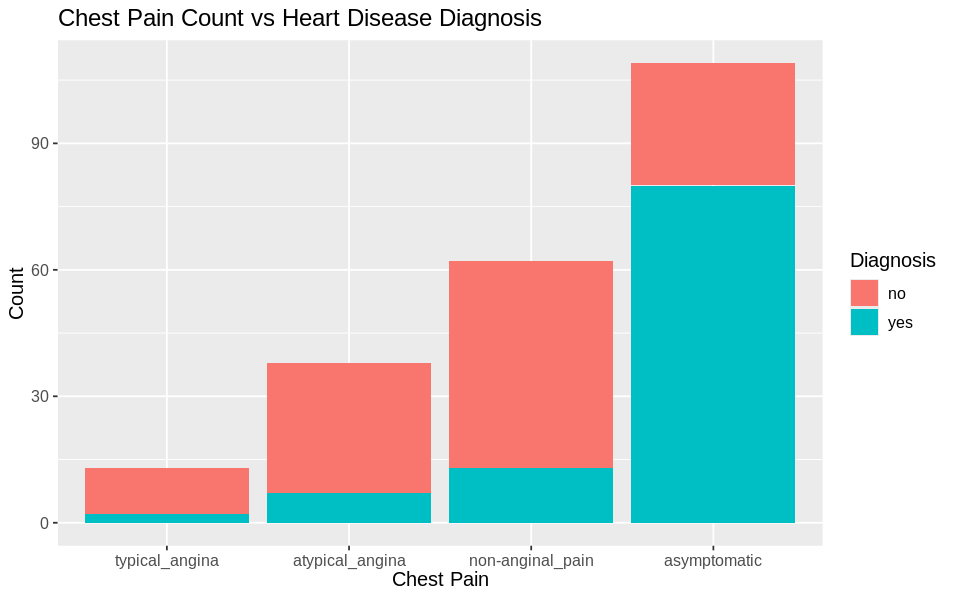

In [5]:
options(repr.plot.width = 8, repr.plot.height = 5)
viz_max <- data_train |>
    ggplot(aes(x = age, y = maximum_heart_rate_achieved,  colour = diagnosis_of_heart_disease)) +
    geom_point() +
    labs(title = "Age vs. Maximum Heart Rate Achieved \n (In Relation to Heart Disease Diagnosis)", x = "Age", y = "Maximum Heart Rate Achieved", colour = "Diagnosis of Heart Disease") +
    theme(text = element_text(size = 12))
viz_max

viz_chest <- data_train |>
    ggplot(aes(x = chest_pain, fill = diagnosis_of_heart_disease)) +
    geom_histogram(stat = "count") +
    labs(title = "Chest Pain Count vs Heart Disease Diagnosis", x = "Chest Pain", fill = "Diagnosis", y = "Count") +
    theme(text = element_text(size = 12))
viz_chest

## Methods

To conduct my data analysis for this project, I will use the K-nearest neighbours classification algorithm. I will use the variables age, chest pain, and maximum heart rate achieved, to predict a heart disease diagnosis. I will first perform cross-validation on my training data set, to find the K value with the highest accuracy. After this, I will create a model and evaluate the estimated accuracy of the classifier on the test set using the predict function. To observe how well age, chest pain, and maximum heart rate achieved, can be used to predict a diagnosis of heart disease. I will do this with two separate models, one which includes all three variables, and one that excludes chest pain. To visualize these results, I believe a scatter plot comparing age on the x-axis,  maximum heart rate achieved on the y-axis, heart disease diagnosis sorted by colour, and chest pain by shape could be used to plot a 'new observation' to observe if our classifier's predictions look reasonable for the first model. For the second model, I would create a visualization which excludes the chest pain variable and is not shaped by this factor, to get a simpler and potentially more effective visualization.

## Expected outcomes and significance

I expect to find that age, and maximum heart rate achieved will prove to be accurate when predicting a diagnosis of heart disease. As for chest pain, as of now, I am unsure if the correlations expressed above truly have any correlation to the diagnosis of heart disease, or if it just so happened that these observations were all asymptomatic. As for impact, I believe that if a strong correlation is observed between maximum heart rate achieved and heart disease diagnosis, it could help individuals be able to keep a better monitor of their own heart health. This project could also allow for a better understanding at which age, your potential for heart disease begins to increase. It will also be useful to spread awareness around the fact that most cases of heart disease are asymptomatic for chest pain, that being if this correlation proves to be valid.


## Citation

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.